# Aula 09 - CARS - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
# import wget
# !python3 -m wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
# !tar -xvzf ml-100k.zip

In [3]:
rating = pd.read_csv('./ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
rating.drop('timestamp', axis=1, inplace=True)
rating.head()

,userId,itemId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
#Load the Movies data
item = pd.read_csv('./ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['itemId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item.drop(columns=['video release date', 'IMDb URL'], inplace=True)

item['year'] = pd.to_numeric(item['release'].str[-4:], errors='coerce')

item['decade_raw'] = ((item['year'] // 10) * 10).astype(str)
item['decade'] = item['decade_raw'].astype(str).str.replace('.0', '', regex=False)

item = item.melt(id_vars=['itemId', 'title', 'decade'], var_name='genre')
item = item[item.value == 1]
item.drop(columns=['value'], inplace=True)
item[item['itemId']==1]

item.head()

,itemId,title,decade,genre
1948,267,unknown,nan,unknown
3054,1373,Good Morning (1971),1970,unknown
3365,2,GoldenEye (1995),1990,Action
3367,4,Get Shorty (1995),1990,Action
3380,17,From Dusk Till Dawn (1996),1990,Action


In [5]:
#Load the User data
user = pd.read_csv('./ml-100k/u.user', sep='|', encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zipcode']

user['age_group'] = pd.cut(user['age'], bins=[0, 12, 17, 50, np.inf], labels=['criança', 'adolescente', 'adulto', 'idoso'], right=True)

user.head()

,userId,age,gender,occupation,zipcode,age_group
0,1,24,M,technician,85711,adulto
1,2,53,F,other,94043,idoso
2,3,23,M,writer,32067,adulto
3,4,24,M,technician,43537,adulto
4,5,33,F,other,15213,adulto


### Obs. Para o exercício abaixo, você poderá resolvê-lo usando a implementação própria contida neste notebook, ou então usar a biblioteca fastFM, cujo exemplo de uso está no notebook Aula09_Exemplos_fastFM.ipynb

***Exercício 01:*** Na aula, vimos a implementação e a aplicação do Factorization Machines (FM) com dois tipos de contexto: gêneros dos filmes e profissão do usuário. Verifique o desempenho do RMSE quando mais informações de contexto são incorporadas:
- Década de lançamento do filme: classifique os filmes por década: 60's, 70's, 80's, 90's, etc. 
- Sexo do usuário: M ou F. 
- Faixa etária: classifique os usuários por faixa etária, por exemplo: criança (até 12 anos), adolescente (13 a 17 anos), adulto (18 a 50 anos) e idoso (acima de 51 anos). 
- CEP: utilizar a biblioteca https://www.pythonpool.com/uszipcode-python/ de acordo com o exemplo abaixo

### Obter informações do usuário a partir do CEP (https://www.pythonpool.com/uszipcode-python/)

In [6]:
# %pip install uszipcode

### Consultando o estado

In [7]:
# from uszipcode import SearchEngine
# engine = SearchEngine()
# zipcode = engine.by_zipcode(85711)

# print(zipcode.state)
#Infezimente depois de muita tentativa frustrada não consegui fazer funcioanr o negócio do CEP, vou manter assim

# Implementando o Factorization Machines visto em aula

### Mapeando usuários, itens e contexto no formato one-hot encodings

In [8]:
users_ext = np.sort(rating.userId.unique())
offset = 0
map_users = {user: idx+offset for idx, user in enumerate(users_ext)}


items_ext = np.sort(rating.itemId.unique())
offset += len(map_users)
map_items = {item: idx+offset for idx, item in enumerate(items_ext)}


genres_ext = np.sort(item.genre.unique())
offset += len(map_items)
map_genres = {genre: idx+offset for idx, genre in enumerate(genres_ext)}


occupation_ext = np.sort(user.occupation.unique())
offset += len(map_genres)
map_occupation = {occup: idx+offset for idx, occup in enumerate(occupation_ext)}


decade_ext = np.sort(item.decade.unique())
offset += len(map_occupation)
map_decades = {dec: idx+offset for idx, dec in enumerate(decade_ext)}


gender_ext = np.sort(user.gender.unique())
offset += len(map_decades)
map_gender = {gen: idx+offset for idx, gen in enumerate(gender_ext)}


age_group_ext = np.sort(user.age_group.unique())
offset += len(map_gender)
map_age_group = {group: idx+offset for idx, group in enumerate(age_group_ext)}
map_age_group

{'adolescente': 2676, 'adulto': 2677, 'criança': 2678, 'idoso': 2679}

### Divisão em treino e teste

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(rating, test_size=.2, random_state=2)

In [10]:
data_train = []
for index, row in train.iterrows():
    user_idx = map_users[row['userId']]
    item_idx = map_items[row['itemId']]
    
    occup_str = user.loc[user.userId == row['userId'], 'occupation'].iloc[0]
    occup_idx = map_occupation[occup_str]

    genres_list = item.loc[item.itemId == row['itemId'], 'genre'].tolist()
    genres_idx = [map_genres[g] for g in genres_list]

    decade_str = item.loc[item.itemId == row['itemId'], 'decade'].iloc[0]
    decade_idx = map_decades[decade_str]
    
    user_row = user.loc[user.userId == row['userId']]
    gender_str = user_row['gender'].iloc[0]
    age_group_str = user_row['age_group'].iloc[0]
    
    gender_idx = map_gender[gender_str]
    age_group_idx = map_age_group[age_group_str]
    
    attr = []
    attr.append(user_idx)
    attr.append(item_idx)
    attr += genres_idx
    attr.append(occup_idx)
    attr.append(decade_idx)
    attr.append(gender_idx)
    attr.append(age_group_idx)
    
    attr.append(row['rating'])
    
    data_train.append(attr)

In [11]:
data_test = []
for index, row in test.iterrows():
    user_idx = map_users[row['userId']]
    item_idx = map_items[row['itemId']]
    
    occup_str = user.loc[user.userId == row['userId'], 'occupation'].iloc[0]
    occup_idx = map_occupation[occup_str]

    genres_list = item.loc[item.itemId == row['itemId'], 'genre'].tolist()
    genres_idx = [map_genres[g] for g in genres_list]

    decade_str = item.loc[item.itemId == row['itemId'], 'decade'].iloc[0]
    decade_idx = map_decades[decade_str]
    
    user_row = user.loc[user.userId == row['userId']]
    gender_str = user_row['gender'].iloc[0]
    age_group_str = user_row['age_group'].iloc[0]
    
    gender_idx = map_gender[gender_str]
    age_group_idx = map_age_group[age_group_str]
    
    attr = []
    attr.append(user_idx)
    attr.append(item_idx)
    attr += genres_idx
    attr.append(occup_idx)
    attr.append(decade_idx)
    attr.append(gender_idx)
    attr.append(age_group_idx)
    attr.append(row['rating'])
    
    data_test.append(attr)

In [12]:
n_attributes = max(max(x) for x in data_train)+1
n_attributes

2680

### Modelo de recomendação

In [13]:
def predict(w0, w, v, x):
    pred = w0
    for i in range(len(x)-1):
        pred += w[x[i]]
        for j in range(i+1, len(x)-1):
            pred += np.dot(v[x[i]], v[x[j]])
            
    if pred < 0:
        pred = 0.0
    if pred > 5:
        pred = 5.0
        
    return pred

In [14]:
from math import sqrt

def train_fm(train, n_attr, dim=5, reg=0.01, lr=0.001, decay=0.1, miter=15):
    w0 = 0
    w = np.zeros(n_attr)
    v = np.random.normal(0.0, 0.1, (n_attr, dim))
    n_samples = len(train)
    
    error = []
    for t in range(miter):
        print('Iter #', t)
        sq_error = 0
        for s in range(n_samples):
            pred = predict(w0, w, v, train[s])
            e_ui = pred - train[s][-1]
            sq_error = sq_error + e_ui**2
            
            w0 = w0 - lr*(e_ui + reg * w0)
            
            for i in range(len(train[s])-1):
                
                w[train[s][i]] = w[train[s][i]] - lr*(e_ui + reg * w[train[s][i]])
                
                for f in range(dim):
                    sum_v = 0
                    for j in range(len(train[s])-1):
                        if train[s][i] != train[s][j]:
                            sum_v += v[train[s][j]][f]
                            
                    v[train[s][i]][f] = v[train[s][i]][f] - lr*(e_ui * sum_v + reg * v[train[s][i]][f])

        error.append(sqrt(sq_error/n_samples))
        lr = lr * (1. / (1. + decay * t))

    return w0, w, v, error

In [15]:
w0, w, v, error = train_fm(data_train, n_attributes)

Iter # 0
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14


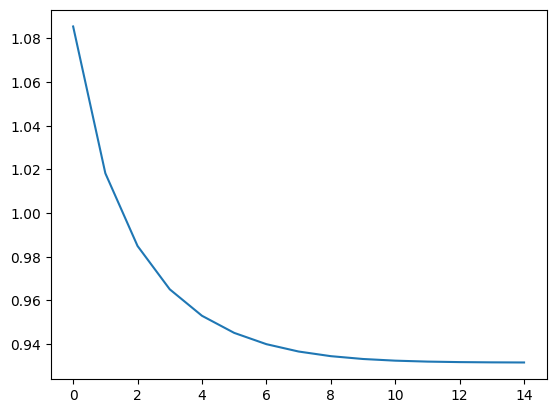

In [16]:
import matplotlib.pyplot as plt

plt.plot(error)
plt.show()

In [17]:
print(data_test[9])
print(predict(w0, w, v, data_test[9]))

[0, 952, 2632, 2641, 2663, 2672, 2675, 2677, 3]
3.92433699764086


In [19]:
def rmse(preds, ratings):
    if len(preds) != len(ratings):
        return -1
    sum = 0
    for i in range(len(preds)):
        sum += pow(preds[i]-ratings[i], 2)
    return sqrt(sum/len(preds))

In [20]:
ratings = []
preds = []
for sample in data_test:
    ratings.append(sample[-1])
    preds.append(predict(w0, w, v, sample))

In [21]:
rmse(preds, ratings)

0.9371313499386664

Ao comparar a métrica de erro rmse gerada apenas com os contextos rpévios com a gerada pelos novos contextos, é notavel uma ligeira melhora nas recomendações. Os valores foram: 0.9735379764519735 para a antiga e 0.9371313499386664 para nova, evidenciando o ganho de desempenho.